# Imports

##### Import content

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/NNN_ANNDL'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/18Dg6_c6vczZjNe1WX6Zio-6RnOUDKCt2/NNN_ANNDL


##### Import libraries

In [ ]:
# Install required dependencies
!pip install keras_cv

# Standard libraries
import math
from datetime import datetime
from collections import Counter
import gc

# Third-party libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision

# KerasCV library
import keras_cv


#Augmentation functions

In [1]:
#Default function to augment data, compatible with .map
def augfn(fn, image):
    image = fn(image)
    return image

In [ ]:
# SCALE (True scale - mean is not 0)
scale_augmentations = [
    keras_cv.layers.RandomZoom(
        height_factor=[0, 0.5],
        width_factor=[0, 0.5],
        fill_mode="nearest",
        interpolation="bilinear"
    ),
    keras_cv.layers.RandomZoom(
        height_factor=[-0.5, 0],
        width_factor=[-0.5, 0],
        fill_mode="nearest",
        interpolation="bilinear"
    )
]

# Create a RandomAugmentationPipeline with scale augmentation
scale_augment = keras_cv.layers.RandomAugmentationPipeline(
    layers=scale_augmentations,
    augmentations_per_image=1,
    rate=0.5
)


In [ ]:
# Define the AugMix, GridMask, and RandAugment augmentation layers
augmix = [
    keras_cv.layers.AugMix(
        value_range=[0, 1],
        severity=0.65,
        num_chains=3,
        chain_depth=[1, 3]
    ),
    keras_cv.layers.GridMask(
        ratio_factor=(0, 0.3),
        rotation_factor=0.6,
        fill_mode="constant",
        fill_value=0
    ),
    keras_cv.layers.RandAugment(
        value_range=[0, 1],
        augmentations_per_image=3,
        magnitude=0.6,
        magnitude_stddev=0.3
    )
]

# Combine the augmentations in a RandomAugmentationPipeline
augmix_augment = keras_cv.layers.RandomAugmentationPipeline(
    layers=augmix,
    augmentations_per_image=2,
    rate=0.8
)


In [ ]:
# Validation augmentations (more severe than training)
valaug = [
    keras_cv.layers.AugMix(
        value_range=[0, 1],
        severity=0.8,
        num_chains=5,
        chain_depth=[1, 5]
    ),
    keras_cv.layers.GridMask(
        ratio_factor=(0, 0.3),
        rotation_factor=0.6,
        fill_mode="constant",
        fill_value=0
    ),
    keras_cv.layers.AutoContrast(
        value_range=[0, 1]
    ),
    keras_cv.layers.RandAugment(
        value_range=[0, 1],
        augmentations_per_image=3,
        magnitude=0.7,
        magnitude_stddev=0.15
    )
]

# Create a RandomAugmentationPipeline for validation augmentations
valaug_augment = keras_cv.layers.RandomAugmentationPipeline(
    layers=valaug,
    augmentations_per_image=2,
    rate=0.8
)

# Validation scaling augmentations
valscale = [
    keras_cv.layers.RandomZoom(
        height_factor=[0, 0.5],
        width_factor=[0, 0.5],
        fill_mode="nearest",
        interpolation="bilinear"
    ),
    keras_cv.layers.RandomZoom(
        height_factor=[-0.5, 0],
        width_factor=[-0.5, 0],
        fill_mode="nearest",
        interpolation="bilinear"
    )
]

# Create a RandomAugmentationPipeline for validation scale augmentations
valscale_augment = keras_cv.layers.RandomAugmentationPipeline(
    layers=valscale,
    augmentations_per_image=1,
    rate=0.5
)


# Import dataset

In [ ]:
# Load outlier filtered dataset
data = np.load("Datasets/dataset_filtered.npz")
images = data['images']
labels = np.squeeze(data['labels'])

# Analyze label distribution
label_counts = Counter(labels.tolist())
max_count = max(label_counts.values())

# Oversample the dataset
def oversample_data(images, labels):
    oversampled_images = []
    oversampled_labels = []

    for label in range(len(label_counts)):
        # Filter samples of the current label
        label_indices = np.where(labels == label)[0]
        current_images = images[label_indices]

        # Oversample to match max_count
        num_to_add = max_count - len(current_images)
        if num_to_add > 0:
            extra_images = current_images[np.random.choice(len(current_images), num_to_add)]
            oversampled_images.extend(extra_images)
            oversampled_labels.extend([label] * num_to_add)

        # Add the existing images and labels
        oversampled_images.extend(current_images)
        oversampled_labels.extend([label] * len(current_images))

    return np.array(oversampled_images), np.array(oversampled_labels)

# Balance the dataset
balanced_images, balanced_labels = oversample_data(images, labels)

# Train-validation split (80%-20%)
train_images, val_images, train_labels, val_labels = train_test_split(
    balanced_images, balanced_labels, test_size=0.2, stratify=balanced_labels, random_state=42
)

# Free up memory by deleting unnecessary variables
del images, labels, balanced_images, balanced_labels, label_counts, max_count

# Create preprocess, augment and postprocess functions
def preprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32)  # Normalize to [0, 1]
    return image, label

def postprocess_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.uint8)  # Normalize to [0, 255]
    return image, label

def base_augment_image(image, label):
    image = augfn(scale_augment, image)
    return image, label

def mix_augment_image(image, label):
    image = augfn(augmix_augment, image)
    return image, label

def val_augment_image(image, label):
    image = augfn(valscale_augment, image)
    image = augfn(valaug_augment, image)
    return image, label

# Create train and validation datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = (
    train_dataset
    .shuffle(len(train_images))  # Shuffle the training set
    .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)  # Normalize images
    .map(base_augment_image, num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentations
    .map(mix_augment_image, num_parallel_calls=tf.data.AUTOTUNE)
    .map(postprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(1024)  # Batch size
    .prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
)

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = (
    val_dataset
    .map(preprocess_image)  # preprocess validation images
    .map(val_augment_image, num_parallel_calls=tf.data.AUTOTUNE) # Val set augmentations
    .map(postprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(512)  # Batch size
    .prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
)

# Free up memory by deleting train and validation arrays
del train_images, train_labels, val_images, val_labels

# Test if datasets are correctly initialized
image_batch, label_batch = next(iter(train_dataset.take(1)))

print(f"Image batch shape: {image_batch.shape}")
print(f"Label batch shape: {label_batch.shape}")

print(f"Image max:{np.max(image_batch)}")
print(f"Image type:{image_batch.dtype}")
print(f"Label type:{label_batch.dtype}")

Image batch shape: (1024, 96, 96, 3)
Label batch shape: (1024,)
Image max:255
Image type:<dtype: 'uint8'>
Label type:<dtype: 'int64'>


219
233
200
255
167
230
210
254
255


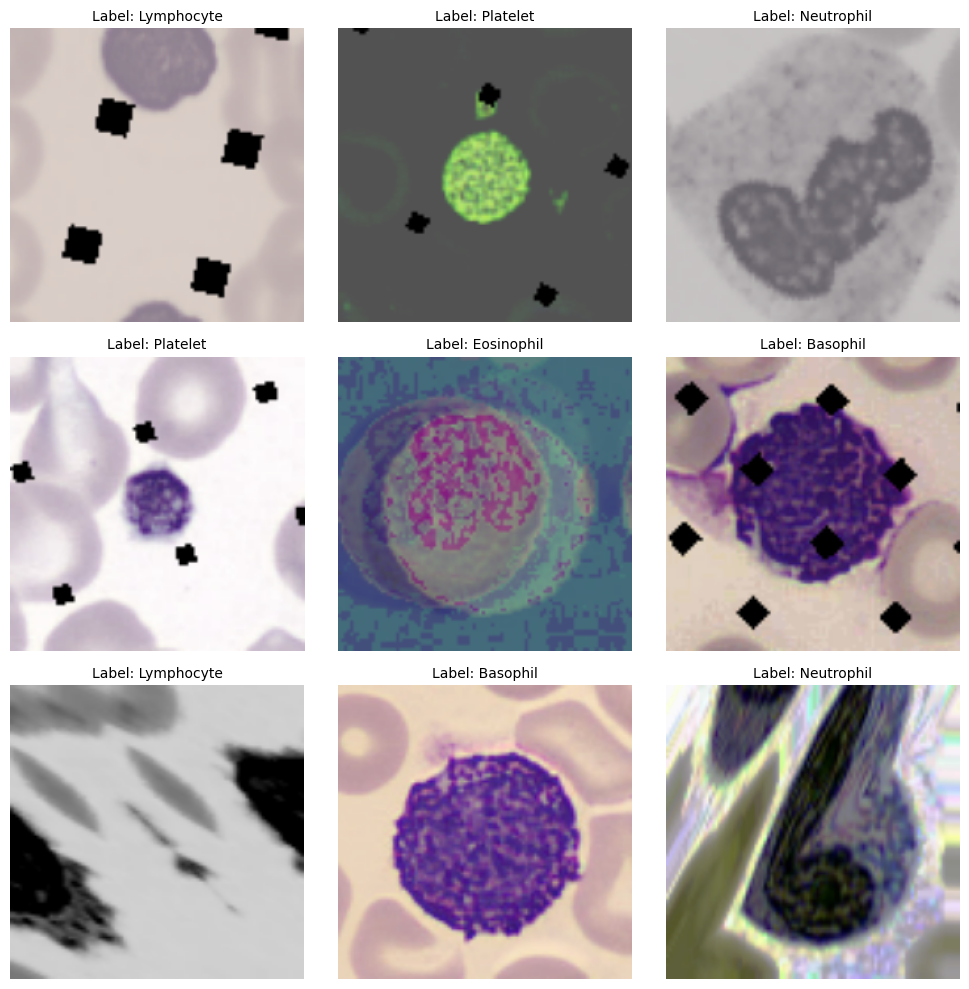

In [ ]:
def plot_9_samples(dataset, label_names=None, target_size=(224, 224)):
    """
    Plots 9 images from the dataset with their respective labels,
    resizing the images to the specified target size.
    """
    plt.figure(figsize=(10, 10))
    resizing_layer = tf.keras.layers.Resizing(*target_size)  # Create resizing layer

    for i, sample in enumerate(dataset.take(9)):  # Take 9 samples
        # Extract image and label
        image = sample[0][0, ...]  # Take the first image in the batch
        label = sample[1][0, ...]  # Take the first label in the batch

        # Resize the image
        resized_image = resizing_layer(image)

        # Convert to numpy for plotting
        resized_image_np = np.array(resized_image)
        print(np.max(resized_image_np))
        if label_names is not None:
            # Map label index to label name
            label_text = label_names[int(label)]
        else:
            # Fallback to just displaying the label index if label names not provided
            label_text = str(label)

        # Plot the image with its label
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.squeeze(resized_image_np))  # Squeeze in case images are grayscale
        plt.title(f"Label: {label_text}", fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Label names for visualization
label_names = {
    0: "Basophil",
    1: "Eosinophil",
    2: "Erythroblast",
    3: "Granulocyte",
    4: "Lymphocyte",
    5: "Monocyte",
    6: "Neutrophil",
    7: "Platelet"
}

# Example usage
plot_9_samples(train_dataset, label_names=label_names, target_size=(224, 224))


# Model build

In [ ]:
from keras.layers import GroupNormalization
from tensorflow.keras import mixed_precision
import tensorflow.keras as tfk

# Set precision policy
mixed_precision.set_global_policy('bfloat16')

#Define build model function
def build_model(model_key, input_shape=(96, 96, 3), num_classes=8):
    model_name, layer_name = model_dict[model_key]
    base_model_class = getattr(tfk.applications, model_name)
    base_model = base_model_class(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape
    )

    base_model.trainable = False

    inputs = tfk.layers.Input(shape=(96, 96, 3))
    x = base_model(inputs)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = GroupNormalization(groups=32, axis=-1)(x)
    x = tfk.layers.Dropout(0.2)(x)
    x = tfk.layers.Dense(512, activation='gelu', kernel_regularizer=tfk.regularizers.l2(0.001))(x)
    x = GroupNormalization(groups=32, axis=-1)(x)
    x = tfk.layers.Dropout(0.2)(x)
    x = tfk.layers.Dense(128, activation='gelu', kernel_regularizer=tfk.regularizers.l2(0.001))(x)
    x = GroupNormalization(groups=32, axis=-1)(x)
    outputs = tfk.layers.Dense(num_classes, activation='softmax')(x)

    model = tfk.Model(inputs=inputs, outputs=outputs, trainable=True)

    # Compile to check integrity
    model.compile(
        optimizer=tf.keras.optimizers.Lion(
            learning_rate=1e-3,
            weight_decay=1e-4
        ),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model, base_model

# Define a model dict where a key is defined to select a tuple containing ('ModelNameFromKerasLibrary', 'base_model_layer_name')
model_dict = {
    'MV3L': ('MobileNetV3Large', 'MobileNetV3Large'),
    'EfV2M': ('EfficientNetV2M', 'efficientnetv2-m'),
    'CNT': ('ConvNeXtTiny', 'convnext_tiny'),
    'CNS': ('ConvNeXtSmall', 'convnext_small'),
    'CNB': ('ConvNeXtBase', 'convnext_base'),
    'MV2': ('MobileNetV2', 'MobileNetV2')
}

# Use the model key to swiftly change used base model
model_key = 'CNT'
model, base_model = build_model(model_key)
model.summary(expand_nested=True)

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_tiny (Functional)           │ (None, 3, 3, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer (InputLayer)        │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 96, 96, 3)           │               0 │
│ convnext_tiny_prestem_normalization  │                             │                 │
│ (Normalization)                      │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ convnext_tiny_stem (Sequential) │ (None, 24, 24, 96)          │           4,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_tiny_stem_conv      │ (None, 24, 24, 96)          │           4,704 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│       └ convnext_tiny_stem_layernorm │ (None, 24, 24, 96)          │             192 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 96)          │           4,800 │
│ convnext_tiny_stage_0_block_0_depth… │                             │                 │
│ (Conv2D)                             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 96)          │             192 │
│ convnext_tiny_stage_0_block_0_layer… │                             │                 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 384)         │          37,248 │
│ convnext_tiny_stage_0_block_0_point… │                             │                 │
│ (Dense)                              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 384)         │               0 │
│ convnext_tiny_stage_0_block_0_gelu   │                             │                 │
│ (Activation)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 96)          │          36,960 │
│ convnext_tiny_stage_0_block_0_point… │                             │                 │
│ (Dense)                              │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └                                 │ (None, 24, 24, 96)          │              96 │
│ convnext_tiny_stage_0_block_0_layer… │                             │                 │
│ (LayerScale)                         │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 29,203,944 (55.70 MB)

 Trainable params: 1,383,816 (2.64 MB)

 Non-trainable params: 27,820,128 (53.06 MB)

# Model training

## Step 1 -> Top layer training until plateau (Can earlystop)

In [ ]:
# Create a timestamp string
timestamp = datetime.now().strftime("%d_%H-%M-%S")

# Create callbacks
checkpoint = ModelCheckpoint(
    f"Submissions/Lolli/{model_key}_{timestamp}.keras",
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-4,
    verbose=1
)

# Recompile model
model.compile(
    optimizer=tf.keras.optimizers.Lion(
        learning_rate=1e-3,
        weight_decay=0.1
    ),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

# Train model
print("\nStarting top layers training phase...")

model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, checkpoint, reduce_lr],
    verbose=1
)

# Clean up
gc.collect()
tf.keras.backend.clear_session()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ convnext_tiny (Functional)           │ (None, 3, 3, 768)           │      27,820,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 768)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization                  │ (None, 768)                 │           1,536 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1024)                │         787,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_1                │ (None, 1024)                │           2,048 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_2                │ (None, 512)                 │           1,024 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ group_normalization_3                │ (None, 128)                 │             256 │
│ (GroupNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,203,944 (55.70 MB)

 Trainable params: 1,383,816 (2.64 MB)

 Non-trainable params: 27,820,128 (53.06 MB)


Starting initial training phase...
Epoch 1/100
 4/15 ━━━━━━━━━━━━━━━━━━━━ 2:15 12s/step - accuracy: 0.1682 - loss: 4.3366

KeyboardInterrupt: 

## Step 2

In [ ]:
# Define the function to keep the pretrained normalization layers frozen
def set_bn_to_inference_mode(model):
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = False

# Gradual unfreezing layers function
def unfreeze_and_train(model, base_model, train_generator, val_generator,
                       initial_lr=1e-5, unfreeze_percentage=0.2,
                       epochs_per_stage=5, min_lr=1e-7):
    """
    Progressively unfreeze and train layers of the base model.

    Args:
        model: The full model including base model and top layers
        base_model: The base model portion (e.g., MobileNetV3Large)
        train_generator: Training data generator
        val_generator: Validation data generator
        initial_lr: Starting learning rate
        unfreeze_percentage: Percentage of layers to unfreeze in each stage
        epochs_per_stage: Number of epochs to train in each stage
        min_lr: Minimum learning rate before stopping
    """
    base_model_layers = base_model.layers
    total_base_model_layers = len(base_model_layers)
    layers_to_unfreeze = math.ceil(total_base_model_layers * unfreeze_percentage)
    current_unfrozen_layers = 0
    current_lr = initial_lr
    best_val_accuracy = 0
    stages_without_improvement = 0

    timestamp = datetime.now().strftime("%d_%H-%M-%S")
    # Create callbacks
    checkpoint = ModelCheckpoint(
        f"Submissions/Lolli/{model_key}_{timestamp}_stage_{current_unfrozen_layers}.keras",
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=min_lr,
        verbose=1
    )

    # Dictionary to store training history
    training_history = {}

    while current_unfrozen_layers < total_base_model_layers:
        stage = current_unfrozen_layers // layers_to_unfreeze + 1

        # Calculate layers to unfreeze for this stage
        end_layer = min(current_unfrozen_layers + layers_to_unfreeze, total_base_model_layers)

        print(f"\n{'='*50}")
        print(f"Starting Stage {stage}, unfreezin {layers_to_unfreeze} layers")
        print(f"{'='*50}")

        # Unfreeze layers for this stage
        for i, layer in enumerate(base_model_layers):
            if i < end_layer:
                layer.trainable = True
            else:
                layer.trainable = False

        set_bn_to_inference_mode(model)

        # Compile model with current learning rate
        model.compile(
            optimizer=tf.keras.optimizers.Lion(
                learning_rate=current_lr,
                weight_decay=0.1
            ),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
            metrics=['accuracy']
        )

        # Train for this stage
        history = model.fit(
            train_generator,
            validation_data=val_generator,
            epochs=epochs_per_stage,
            callbacks=[checkpoint, early_stopping, reduce_lr],
            verbose=1
        )

        # Store history for this stage
        training_history[f'stage_{stage}'] = {
            'accuracy': history.history['accuracy'],
            'val_accuracy': history.history['val_accuracy'],
            'loss': history.history['loss'],
            'val_loss': history.history['val_loss']
        }

        # Check if we should continue training
        current_val_accuracy = max(history.history['val_accuracy'])
        if current_val_accuracy > best_val_accuracy:
            best_val_accuracy = current_val_accuracy
            stages_without_improvement = 0
        else:
            stages_without_improvement += 1

        # Early stopping across stages
        if stages_without_improvement >= 2:
            print("\nStopping early due to no improvement across stages")
            break

        # Update learning rate and unfrozen layers count
        current_lr = max(current_lr * 0.5, min_lr)
        if current_lr <= min_lr:
            print("\nReached minimum learning rate, stopping training")
            break

        current_unfrozen_layers = end_layer
        tf.keras.backend.clear_session()
        gc.collect()

    return training_history

# Define plot training history function
def plot_training_history(history):
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for stage in history:
        plt.plot(history[stage]['accuracy'], label=f'{stage}_train')
        plt.plot(history[stage]['val_accuracy'], label=f'{stage}_val')
    plt.title('Model Accuracy Across Stages')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for stage in history:
        plt.plot(history[stage]['loss'], label=f'{stage}_train')
        plt.plot(history[stage]['val_loss'], label=f'{stage}_val')
    plt.title('Model Loss Across Stages')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Start the training
training_history = unfreeze_and_train(
    model=model,
    base_model=base_model,
    train_generator=train_dataset,
    val_generator=val_dataset,
    initial_lr=1e-3,
    unfreeze_percentage=1,
    epochs_per_stage=30,
    min_lr=1e-7
)
# Plot History
plot_training_history(training_history)

LOADING A EXISTING MODEL!

Starting Stage 1, unfreezin 133 layers
Epoch 1/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.5516 - loss: 3.4256 
Epoch 1: val_accuracy improved from -inf to 0.64539, saving model to Submissions/Lolli/CNT_22_12-17-38_stage_0.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 486s 27s/step - accuracy: 0.5518 - loss: 3.4172 - val_accuracy: 0.6454 - val_loss: 2.7663 - learning_rate: 0.0010
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5659 - loss: 2.8209 
Epoch 2: val_accuracy improved from 0.64539 to 0.64726, saving model to Submissions/Lolli/CNT_22_12-17-38_stage_0.keras
15/15 ━━━━━━━━━━━━━━━━━━━━ 364s 24s/step - accuracy: 0.5659 - loss: 2.8135 - val_accuracy: 0.6473 - val_loss: 2.2373 - learning_rate: 0.0010
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18s/step - accuracy: 0.5832 - loss: 2.2925 
Epoch 3: val_accuracy did not improve from 0.64726
15/15 ━━━━━━━━━━━━━━━━━━━━ 360s 24s/step - accuracy: 0.5830 - loss: 2.2876 - val_accuracy: 0.6451 - val_loss: